# Monitoring Forests Using Aerial Imagery

## Data handling and preparation

# Base model 0 & Set up

## Setup

### Imports

In [1]:
import tensorflow as tf
import numpy as np
import csv
import os
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, datasets, metrics, Sequential, utils
from tensorflow.keras.layers import *
from IPython.display import HTML, display
import matplotlib.pyplot as plt
%matplotlib inline

### Defining constants

In [2]:
data_dir = '/datasets/treesat'
label_level = 2

In [3]:
IMAGE_RESCALE = (304, 304)
input_shape = (IMAGE_RESCALE[0], IMAGE_RESCALE[1], 4)
batch_size = 128
label_key = f'level_{label_level}'

In [9]:
METRICS = [
      lambda : tf.keras.metrics.TruePositives(name='tp'),
      lambda : tf.keras.metrics.FalsePositives(name='fp'),
      lambda : tf.keras.metrics.TrueNegatives(name='tn'),
      lambda : tf.keras.metrics.FalseNegatives(name='fn'), 

      lambda : tf.keras.metrics.CategoricalAccuracy(name='Cataccuracy'),
      lambda : tf.keras.metrics.Accuracy(name='accuracy'),
      lambda : tf.keras.metrics.Precision(name='precision'),
      lambda : tf.keras.metrics.Recall(name='recall'),
      lambda : tf.keras.metrics.F1Score(name='f1Score', average='micro'),
      lambda: tf.keras.metrics.AUC(name='auc', multi_label=True)
    
]

def fresh_metrics():
    return [metric() for metric in METRICS]

### Loading data

In [4]:
train_file_labels = tf.data.experimental.make_csv_dataset(
    os.path.join(data_dir, 'train_file_labels.csv'), batch_size=batch_size, num_epochs=1)
train_file_labels = train_file_labels.unbatch()

In [5]:
validation_file_labels = tf.data.experimental.make_csv_dataset(
    os.path.join(data_dir, 'validation_file_labels.csv'), 
    batch_size=batch_size, num_epochs=1,
    shuffle=False)
validation_file_labels = validation_file_labels.unbatch()

In [6]:
test_file_labels = tf.data.experimental.make_csv_dataset(
    os.path.join(data_dir, 'test_file_labels.csv'), 
    batch_size=batch_size, num_epochs=1,
    shuffle=False)
test_file_labels = test_file_labels.unbatch()

In [7]:
encoder_vocab_file = os.path.join(data_dir, f'level_{label_level}_vocabulary.txt')
label_encoder = StringLookup(vocabulary=encoder_vocab_file, num_oov_indices=0, output_mode='one_hot')

num_classes = len(label_encoder.get_vocabulary())

label_lookup = {i: n for i, n in enumerate(label_encoder.get_vocabulary())}
label_lookup

{0: 'larch',
 1: 'cleared',
 2: 'beech',
 3: 'oak',
 4: 'douglas fir',
 5: 'pine',
 6: 'fir',
 7: 'short-lived deciduous',
 8: 'long-lived deciduous',
 9: 'spruce'}

### functions

In [14]:
def pretty_cm(cm):
    result_table  = '<h3>Confusion matrix</h3>\n'
    result_table += '<table border=1>\n'
    result_table += f'<tr><td>&nbsp;</td><td>&nbsp;</td><th colspan={len(label_lookup)}>Predicted labels</th></tr>\n'
    result_table += '<tr><td>&nbsp;</td><td>&nbsp;</td>'

    for _, cn in sorted(label_lookup.items()):
        result_table += f'<td><strong>{cn}</strong></td>'
    result_table += '</tr>\n'

    result_table += '<tr>\n'
    result_table += f'<th rowspan={len(label_lookup) + 1}>Actual labels</th>\n'

    for ai, an in sorted(label_lookup.items()):
        result_table += '<tr>\n'
        result_table += f'  <td><strong>{an}</strong></td>\n'
        for pi, pn in sorted(label_lookup.items()):
            result_table += f'  <td>{cm[ai, pi]}</td>\n'
        result_table += '</tr>\n'
    result_table += "</table>"
    # print(result_table)
    display(HTML(result_table))

In [15]:
# Adjusted load_image function to accept file_path and label separately
def load_image(file_path, label):
    # read the image from disk, decode it, resize it, and scale the pixels intensities to the range [0, 1]
    image = tf.io.read_file(file_path)
    image = tf.io.decode_png(image, channels=4)
    image = tf.image.resize(image, IMAGE_RESCALE)
    image /= 255.0
    
    # grab the label and encode it
    encoded_label = label_encoder(label)
    
    # return the image and the one-hot encoded label
    return image, encoded_label

### Loading the images

In [16]:
train_data = train_file_labels.map(lambda fl: (fl['file_name'], fl[label_key]), 
                                      num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(200)
train_data = train_data.map(load_image, 
                                      num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

In [17]:
validation_data = validation_file_labels.map(lambda fl: (fl['file_name'], fl[label_key]), 
                                      num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.map(load_image, 
                                      num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

In [18]:
test_data = test_file_labels.map(lambda fl: (fl['file_name'], fl[label_key]), 
                                      num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(load_image, 
                                      num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

## Explore the data

### Class distribution

In [19]:
class_counts = train_file_labels.map(lambda fl: label_encoder(fl[label_key]))
class_counts = class_counts.reduce(tf.zeros((num_classes,)),
                             lambda o, l: tf.math.add(o, l)).numpy()
class_counts

array([2145., 2844., 4508., 5515., 1896., 5324.,  687., 4131., 4118.,
       4098.], dtype=float32)

In [20]:
all_train_size = sum(class_counts)
all_train_size

35266.0

In [21]:
class_weights = tf.constant([all_train_size / (10 * cc) for cc in class_counts])
class_weights

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([1.64410256, 1.24001406, 0.78229814, 0.63945603, 1.8600211 ,
       0.66239669, 5.13333333, 0.8536916 , 0.8563866 , 0.86056613])>

In [22]:
def add_weight(image, one_hot_label):
    label = tf.argmax(one_hot_label)
    return image, one_hot_label, class_weights[label]

In [23]:
weighted_train_data = train_data.unbatch().map(add_weight)
weighted_train_data

<_MapDataset element_spec=(TensorSpec(shape=(304, 304, 4), dtype=tf.float32, name=None), TensorSpec(shape=(10,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>

In [24]:
weighted_train_data = weighted_train_data.shuffle(200)
weighted_train_data = weighted_train_data.batch(batch_size)
weighted_train_data = weighted_train_data.prefetch(tf.data.AUTOTUNE)

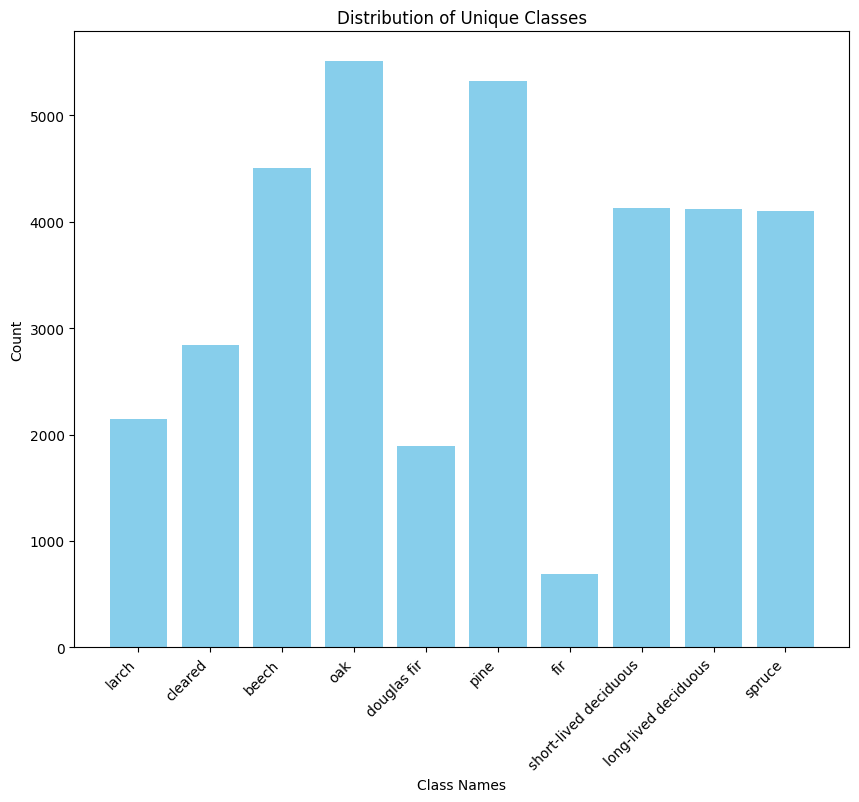

In [25]:
# Plot distribution using class names
plt.figure(figsize=(10, 8))
plt.bar(label_encoder.get_vocabulary(), class_counts, color='skyblue')
plt.xlabel("Class Names")
plt.ylabel("Count")
plt.title("Distribution of Unique Classes")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()  # Display the plotted distribution

### sample images

In [ ]:
sample_images, sample_labels = train_data.as_numpy_iterator().next()

plt.figure(figsize=(10, 10))
for i in range(16):  # Adjust this number based on how many images you want to display
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(sample_images[i, ..., :-1]) # drop the alpha channel, to make the images more like you'd see
#     plt.imshow(sample_images[i]) # image with alpha channel
    label_index = np.argmax(sample_labels[i])
    class_name = label_lookup[label_index]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(class_name)

## Create and train a base model (Model 0?)

In [21]:
model_base = Sequential([
    Conv2D(8, (5, 5), padding='same', activation='relu', input_shape=input_shape),
    Conv2D(8, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
   
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 304, 304, 8)       808       
                                                                 
 conv2d_1 (Conv2D)           (None, 304, 304, 8)       1608      
                                                                 
 max_pooling2d (MaxPooling2  (None, 76, 76, 8)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 46208)             0         
                                                                 
 dense (Dense)               (None, 128)               5914752   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

In [22]:
model_base.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model_base.fit(
    train_data,
    epochs=10,
    validation_data=validation_data,
    verbose=1
)

model_base.save('model_base.keras')
with open('model_base_history.json', 'w') as f:
    json.dump(history.history, f)

Epoch 1/10
276/276 [==============================] - 85s 284ms/step - loss: 2.1611 - accuracy: 0.2352 - val_loss: 1.9970 - val_accuracy: 0.2757
Epoch 2/10
276/276 [==============================] - 74s 269ms/step - loss: 1.8731 - accuracy: 0.3292 - val_loss: 1.9027 - val_accuracy: 0.3108
Epoch 3/10
276/276 [==============================] - 74s 269ms/step - loss: 1.7287 - accuracy: 0.3900 - val_loss: 1.8449 - val_accuracy: 0.3370
Epoch 4/10
276/276 [==============================] - 75s 271ms/step - loss: 1.5570 - accuracy: 0.4551 - val_loss: 1.9440 - val_accuracy: 0.3412
Epoch 5/10
276/276 [==============================] - 75s 269ms/step - loss: 1.2868 - accuracy: 0.5560 - val_loss: 2.0595 - val_accuracy: 0.3299
Epoch 6/10
276/276 [==============================] - 75s 269ms/step - loss: 0.9554 - accuracy: 0.6736 - val_loss: 2.3683 - val_accuracy: 0.3081
Epoch 7/10
276/276 [==============================] - 75s 269ms/step - loss: 0.6529 - accuracy: 0.7819 - val_loss: 2.9024 - val_ac

In [23]:
model_base = tf.keras.models.load_model('model_base.keras')

with open('model_base_history.json') as f:
    model_base_history = json.load(f)

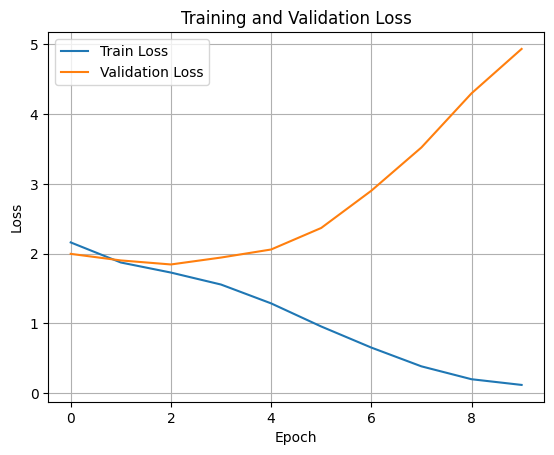

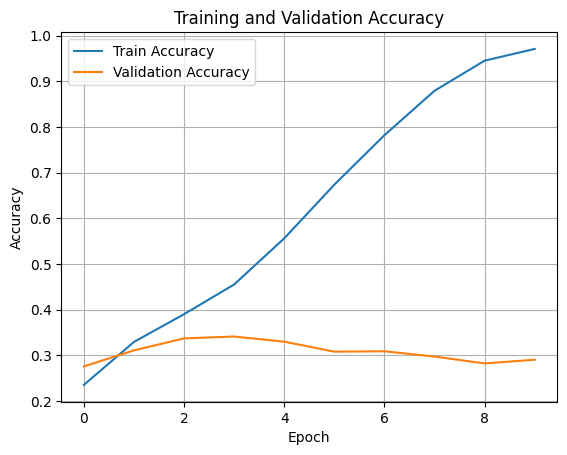

In [24]:
# Assuming history contains the training history returned by model.fit
train_loss = model_base_history['loss']
val_loss = model_base_history['val_loss']
train_acc = model_base_history['accuracy']
val_acc = model_base_history['val_accuracy']

# Plot loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Evaluate base model

In [25]:
model_base.evaluate(test_data, return_dict=True)

79/79 [==============================] - 18s 230ms/step - loss: 5.0734 - accuracy: 0.2934


{'loss': 5.073359489440918, 'accuracy': 0.2934405207633972}

In [26]:
test_predictions = model_base.predict(test_data)

79/79 [==============================] - 17s 210ms/step


In [27]:
predict_labels = np.argmax(test_predictions, axis=1)
test_labels = np.array(list(test_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_labels = np.argmax(test_labels, axis=1)
cm = tf.math.confusion_matrix(test_labels, predict_labels).numpy()
pretty_cm(cm)

# More complex base model (Model 1 & 2)

Run with level 1 labels for model 2 (I just made a copy of this whole notebook and changed the labels to level 1 rather than either re rewrite the code or overwrite the model's graphs and results)

In [23]:
model_complex = Sequential([
    Conv2D(filters=8, kernel_size=10, padding='same', input_shape=input_shape, activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Conv2D(filters=16, kernel_size=5, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Dropout(rate=0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_complex.summary()   

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 304, 304, 8)       3208      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 152, 152, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 152, 152, 16)      3216      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 76, 76, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 76, 76, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 38, 38, 32)       

In [8]:
#Copy to make the graphic with
model_1 = Sequential([
    Conv2D(filters=8, kernel_size=10, padding='same', input_shape=input_shape, activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Conv2D(filters=16, kernel_size=5, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Dropout(rate=0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model_1.save('example_model1.h5',save_format='h5')
model_1.summary()   

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 304, 304, 8)       3208      
                                                                 
 max_pooling2d (MaxPooling2  (None, 76, 76, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 76, 76, 16)        3216      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 19, 19, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 32)          0

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
model_complex.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model_complex.fit(
    train_data,
    epochs=10,
    validation_data=validation_data,
    verbose=1
)

model_complex.save('model_complex.keras')
with open('model_complex_history.json', 'w') as f:
    json.dump(history.history, f)

Epoch 1/10


2024-05-25 20:03:48.018203: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


276/276 [==============================] - 95s 313ms/step - loss: 2.0793 - accuracy: 0.2278 - val_loss: 1.9676 - val_accuracy: 0.2940
Epoch 2/10
276/276 [==============================] - 83s 301ms/step - loss: 1.8601 - accuracy: 0.3165 - val_loss: 1.7582 - val_accuracy: 0.3569
Epoch 3/10
276/276 [==============================] - 83s 300ms/step - loss: 1.7169 - accuracy: 0.3871 - val_loss: 1.7050 - val_accuracy: 0.3839
Epoch 4/10
276/276 [==============================] - 84s 302ms/step - loss: 1.6179 - accuracy: 0.4270 - val_loss: 1.6035 - val_accuracy: 0.4276
Epoch 5/10
276/276 [==============================] - 83s 301ms/step - loss: 1.5212 - accuracy: 0.4584 - val_loss: 1.5532 - val_accuracy: 0.4500
Epoch 6/10
276/276 [==============================] - 84s 302ms/step - loss: 1.4372 - accuracy: 0.4831 - val_loss: 1.5511 - val_accuracy: 0.4498
Epoch 7/10
276/276 [==============================] - 83s 301ms/step - loss: 1.3618 - accuracy: 0.5171 - val_loss: 1.5672 - val_accuracy: 0.4

In [21]:
model_complex = tf.keras.models.load_model('model_complex.keras')

with open('model_complex_history.json') as f:
   model_complex_history = json.load(f)

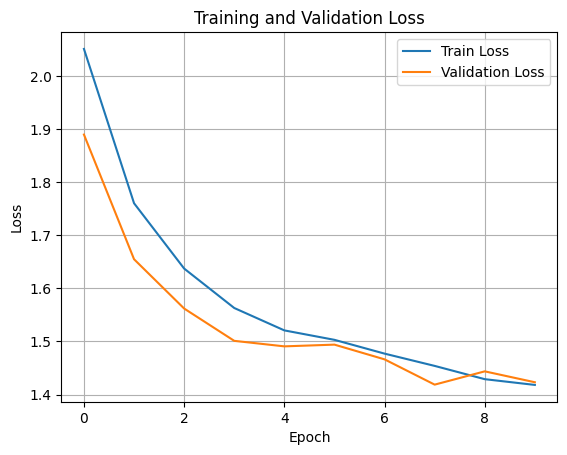

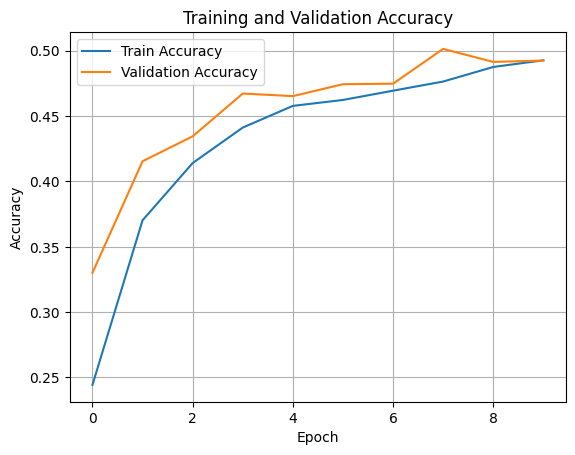

In [22]:
# Assuming history contains the training history returned by model.fit
train_loss = model_complex_history['loss']
val_loss = model_complex_history['val_loss']
train_acc = model_complex_history['accuracy']
val_acc = model_complex_history['val_accuracy']

# Plot loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
model_complex.evaluate(test_data, return_dict=True)

79/79 [==============================] - 21s 232ms/step - loss: 1.4063 - accuracy: 0.4920


{'loss': 1.4062886238098145, 'accuracy': 0.49201151728630066}

In [26]:
test_predictions = model_complex.predict(test_data)

79/79 [==============================] - 16s 201ms/step


In [27]:
predict_labels = np.argmax(test_predictions, axis=1)
test_labels = np.array(list(test_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_labels = np.argmax(test_labels, axis=1)
cm = tf.math.confusion_matrix(test_labels, predict_labels).numpy()
pretty_cm(cm)

In [23]:
model_complex.compile(metrics=fresh_metrics())
model_complex_results = model_complex.evaluate(test_data, verbose=1, return_dict=True)
model_complex_results

79/79 [==============================] - 20s 236ms/step - loss: 0.0000e+00 - tp: 2995.0000 - fp: 1363.0000 - tn: 89330.0000 - fn: 7082.0000 - Cataccuracy: 0.4920 - accuracy: 0.0000e+00 - precision: 0.6872 - recall: 0.2972 - f1Score: 0.4920 - auc: 0.8662


{'loss': 0.0,
 'tp': 2995.0,
 'fp': 1363.0,
 'tn': 89330.0,
 'fn': 7082.0,
 'Cataccuracy': 0.49201151728630066,
 'accuracy': 0.0,
 'precision': 0.6872418522834778,
 'recall': 0.2972114682197571,
 'f1Score': 0.49201151728630066,
 'auc': 0.8662424087524414}

# Data Augmentation (Model 3)

In [21]:
norm_layer = layers.Normalization(input_shape=input_shape)
norm_layer.adapt(train_data.map(lambda x, y: x))

model_aug = Sequential([
    norm_layer,
    Conv2D(filters=8, kernel_size=10, padding='same', input_shape=input_shape, activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Conv2D(filters=16, kernel_size=5, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Dropout(rate=0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_aug.summary()   

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 304, 304, 4)       9         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 304, 304, 8)       3208      
                                                                 
 max_pooling2d (MaxPooling2  (None, 76, 76, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 76, 76, 16)        3216      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 19, 19, 16)        0         
 g2D)                                                            
                                                        

In [22]:
# Image Translation 
data_augmentation = tf.keras.Sequential([
  layers.RandomTranslation(height_factor=0.2, width_factor=0.2)
])

# Augmented all the images in our train_data
aug_train_data = train_data.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
aug_train_data = aug_train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
model_aug.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model_aug.fit(
    aug_train_data,
    epochs=10,
    validation_data=validation_data,
    verbose=1
)

model_aug.save('model_aug.keras')
with open('model_aug_history.json', 'w') as f:
    json.dump(history.history, f)

Epoch 1/10


2024-05-22 15:51:48.772659: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


276/276 [==============================] - 207s 718ms/step - loss: 1.8370 - accuracy: 0.3377 - val_loss: 1.5719 - val_accuracy: 0.4410
Epoch 2/10
276/276 [==============================] - 208s 747ms/step - loss: 1.5764 - accuracy: 0.4361 - val_loss: 1.5548 - val_accuracy: 0.4361
Epoch 3/10
276/276 [==============================] - 207s 745ms/step - loss: 1.5005 - accuracy: 0.4640 - val_loss: 1.4381 - val_accuracy: 0.4833
Epoch 4/10
276/276 [==============================] - 207s 745ms/step - loss: 1.4675 - accuracy: 0.4767 - val_loss: 1.4711 - val_accuracy: 0.4627
Epoch 5/10
276/276 [==============================] - 207s 743ms/step - loss: 1.4406 - accuracy: 0.4855 - val_loss: 1.4247 - val_accuracy: 0.4865
Epoch 6/10
276/276 [==============================] - 208s 747ms/step - loss: 1.4160 - accuracy: 0.4984 - val_loss: 1.3471 - val_accuracy: 0.5234
Epoch 7/10
276/276 [==============================] - 207s 743ms/step - loss: 1.4002 - accuracy: 0.5023 - val_loss: 1.3334 - val_accura

In [28]:
model_aug = tf.keras.models.load_model('model_aug.keras')

with open('model_aug_history.json') as f:
   model_aug_history = json.load(f)

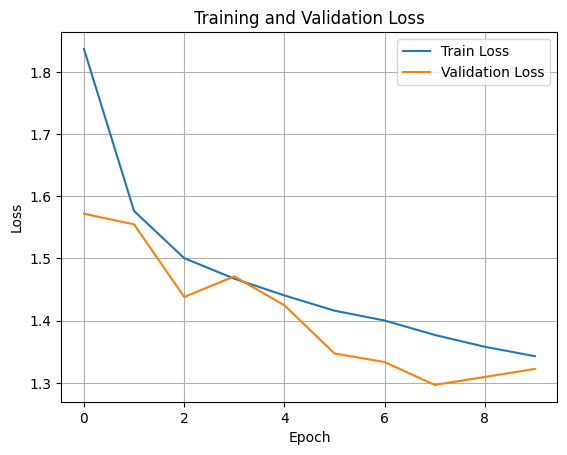

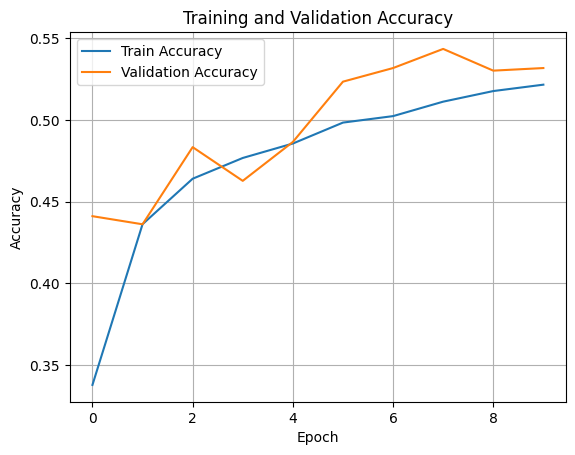

In [29]:
# Assuming history contains the training history returned by model.fit
train_loss = model_aug_history['loss']
val_loss = model_aug_history['val_loss']
train_acc = model_aug_history['accuracy']
val_acc = model_aug_history['val_accuracy']

# Plot loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
model_aug.evaluate(test_data, return_dict=True)

79/79 [==============================] - 19s 234ms/step - loss: 1.3182 - accuracy: 0.5286


{'loss': 1.318243145942688, 'accuracy': 0.5286295413970947}

In [27]:
test_predictions = model_aug.predict(test_data)

79/79 [==============================] - 16s 202ms/step


In [28]:
predict_labels = np.argmax(test_predictions, axis=1)
test_labels = np.array(list(test_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_labels = np.argmax(test_labels, axis=1)
cm = tf.math.confusion_matrix(test_labels, predict_labels).numpy()
pretty_cm(cm)

In [30]:
model_aug.compile(metrics=fresh_metrics())
model_aug_results = model_aug.evaluate(test_data, verbose=1, return_dict=True)
model_aug_results

79/79 [==============================] - 16s 195ms/step - loss: 0.0000e+00 - tp: 3634.0000 - fp: 1481.0000 - tn: 89212.0000 - fn: 6443.0000 - accuracy: 0.5286 - precision: 0.7105 - recall: 0.3606 - f1Score: 0.5286 - auc: 0.8841


{'loss': 0.0,
 'tp': 3634.0,
 'fp': 1481.0,
 'tn': 89212.0,
 'fn': 6443.0,
 'accuracy': 0.5286295413970947,
 'precision': 0.7104594111442566,
 'recall': 0.36062321066856384,
 'f1Score': 0.5286295413970947,
 'auc': 0.8840961456298828}

# Add weightings (Model 4)

In [21]:
#norm_layer = layers.Normalization(input_shape=input_shape)
#norm_layer.adapt(train_data.map(lambda x, y: x))

model_weighting = Sequential([
    Conv2D(filters=8, kernel_size=10, padding='same', input_shape=input_shape, activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Conv2D(filters=16, kernel_size=5, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Dropout(rate=0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_weighting.summary()  

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 304, 304, 8)       3208      
                                                                 
 max_pooling2d (MaxPooling2  (None, 76, 76, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 76, 76, 16)        3216      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 19, 19, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 32)          0

In [22]:
model_weighting.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model_weighting.fit(
    weighted_train_data,
    epochs=10,
    validation_data=validation_data,
    verbose=1
)

model_weighting.save('model_weighting.keras')
with open('model_weighting_history.json', 'w') as f:
    json.dump(history.history, f)

Epoch 1/10


2024-05-22 16:28:49.673354: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


276/276 [==============================] - 95s 317ms/step - loss: 2.1953 - accuracy: 0.1579 - val_loss: 2.0545 - val_accuracy: 0.2376
Epoch 2/10
276/276 [==============================] - 85s 304ms/step - loss: 1.9327 - accuracy: 0.2857 - val_loss: 1.8437 - val_accuracy: 0.3172
Epoch 3/10
276/276 [==============================] - 81s 289ms/step - loss: 1.7645 - accuracy: 0.3620 - val_loss: 1.6817 - val_accuracy: 0.4025
Epoch 4/10
276/276 [==============================] - 81s 289ms/step - loss: 1.6836 - accuracy: 0.3941 - val_loss: 1.6230 - val_accuracy: 0.4194
Epoch 5/10
276/276 [==============================] - 81s 289ms/step - loss: 1.6244 - accuracy: 0.4111 - val_loss: 1.6234 - val_accuracy: 0.4150
Epoch 6/10
276/276 [==============================] - 81s 290ms/step - loss: 1.5914 - accuracy: 0.4226 - val_loss: 1.5817 - val_accuracy: 0.4283
Epoch 7/10
276/276 [==============================] - 80s 288ms/step - loss: 1.5616 - accuracy: 0.4325 - val_loss: 1.5868 - val_accuracy: 0.4

In [31]:
model_weighting = tf.keras.models.load_model('model_weighting.keras')

with open('model_weighting_history.json') as f:
   model_weighting_history = json.load(f)

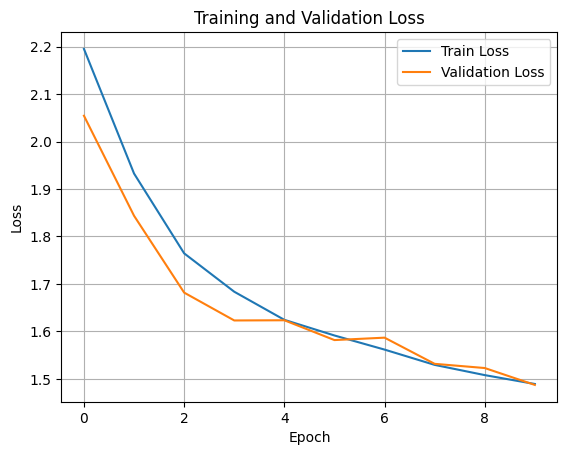

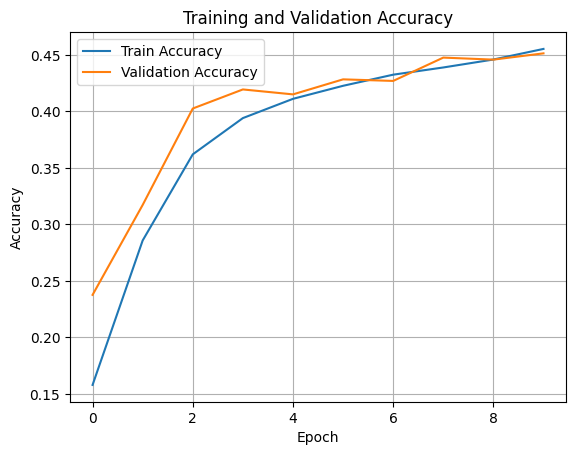

In [24]:
# Assuming history contains the training history returned by model.fit
train_loss = model_weighting_history['loss']
val_loss = model_weighting_history['val_loss']
train_acc = model_weighting_history['accuracy']
val_acc = model_weighting_history['val_accuracy']

# Plot loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
model_weighting.evaluate(test_data, return_dict=True)

79/79 [==============================] - 19s 236ms/step - loss: 1.4768 - accuracy: 0.4686


{'loss': 1.4768047332763672, 'accuracy': 0.4685918390750885}

In [26]:
test_predictions = model_weighting.predict(test_data)

79/79 [==============================] - 16s 201ms/step


In [27]:
predict_labels = np.argmax(test_predictions, axis=1)
test_labels = np.array(list(test_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_labels = np.argmax(test_labels, axis=1)
cm = tf.math.confusion_matrix(test_labels, predict_labels).numpy()
pretty_cm(cm)

In [32]:
model_weighting.compile(metrics=fresh_metrics())
model_weighting_results = model_weighting.evaluate(test_data, verbose=1, return_dict=True)
model_weighting_results

79/79 [==============================] - 16s 196ms/step - loss: 0.0000e+00 - tp: 2202.0000 - fp: 914.0000 - tn: 89779.0000 - fn: 7875.0000 - accuracy: 0.4686 - precision: 0.7067 - recall: 0.2185 - f1Score: 0.4686 - auc: 0.8618


{'loss': 0.0,
 'tp': 2202.0,
 'fp': 914.0,
 'tn': 89779.0,
 'fn': 7875.0,
 'accuracy': 0.4685918390750885,
 'precision': 0.7066752314567566,
 'recall': 0.21851742267608643,
 'f1Score': 0.4685918390750885,
 'auc': 0.8618484735488892}

# Changed model with double conv layers (Model 5)

In [27]:
model_changed = Sequential([
    Conv2D(filters=8, kernel_size=10, padding='same', input_shape=input_shape, activation='relu'),
    Conv2D(filters=8, kernel_size=10, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=16, kernel_size=5, padding='same', activation='relu'),
    Conv2D(filters=16, kernel_size=5, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Dropout(rate=0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_changed.summary()  

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 304, 304, 8)       3208      
                                                                 
 conv2d_13 (Conv2D)          (None, 304, 304, 8)       6408      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 152, 152, 8)       0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 152, 152, 16)      3216      
                                                                 
 conv2d_15 (Conv2D)          (None, 152, 152, 16)      6416      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 38, 38, 16)        0         
 ng2D)                                                

In [28]:
model_changed.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model_changed.fit(
    train_data,
    epochs=10,
    validation_data=validation_data,
    verbose=1
)

model_changed.save('model_changed.keras')
with open('model_changed_history.json', 'w') as f:
    json.dump(history.history, f)

Epoch 1/10


2024-05-25 20:24:00.243929: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


276/276 [==============================] - 201s 663ms/step - loss: 1.9727 - accuracy: 0.2673 - val_loss: 1.6820 - val_accuracy: 0.3888
Epoch 2/10
276/276 [==============================] - 176s 637ms/step - loss: 1.6401 - accuracy: 0.3982 - val_loss: 1.5854 - val_accuracy: 0.4115
Epoch 3/10
276/276 [==============================] - 176s 637ms/step - loss: 1.5194 - accuracy: 0.4477 - val_loss: 1.4622 - val_accuracy: 0.4680
Epoch 4/10
276/276 [==============================] - 176s 638ms/step - loss: 1.4409 - accuracy: 0.4772 - val_loss: 1.4670 - val_accuracy: 0.4680
Epoch 5/10
276/276 [==============================] - 176s 637ms/step - loss: 1.3829 - accuracy: 0.4980 - val_loss: 1.4275 - val_accuracy: 0.4794
Epoch 6/10
276/276 [==============================] - 176s 636ms/step - loss: 1.3236 - accuracy: 0.5212 - val_loss: 1.3526 - val_accuracy: 0.5175
Epoch 7/10
276/276 [==============================] - 176s 637ms/step - loss: 1.2770 - accuracy: 0.5405 - val_loss: 1.2991 - val_accura

In [29]:
model_changed = tf.keras.models.load_model('model_changed.keras')

with open('model_changed_history.json') as f:
   model_changed_history = json.load(f)

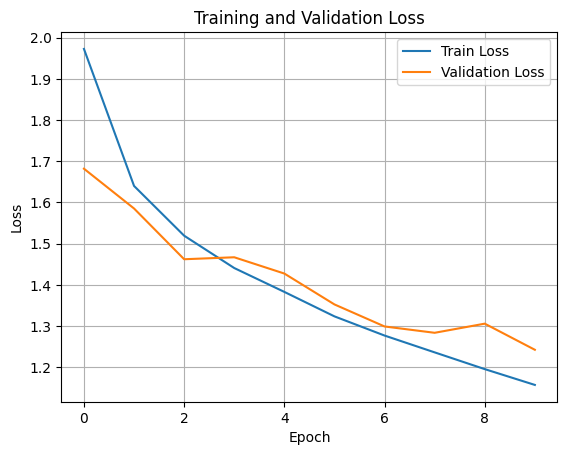

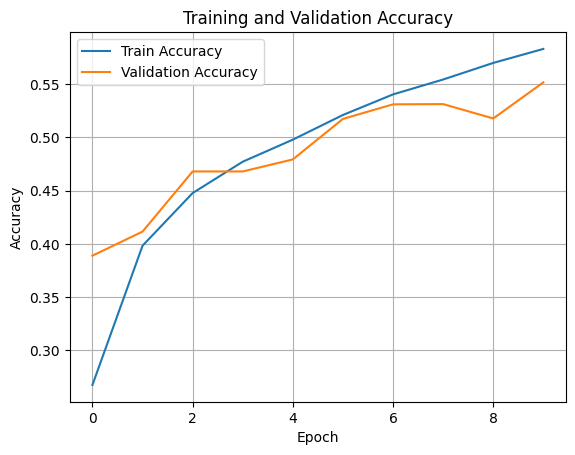

In [30]:
# Assuming history contains the training history returned by model.fit
train_loss = model_changed_history['loss']
val_loss = model_changed_history['val_loss']
train_acc = model_changed_history['accuracy']
val_acc = model_changed_history['val_accuracy']

# Plot loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
model_changed.evaluate(test_data, return_dict=True)

79/79 [==============================] - 21s 257ms/step - loss: 1.2455 - accuracy: 0.5544


{'loss': 1.245507836341858, 'accuracy': 0.5544309020042419}

In [32]:
test_predictions = model_changed.predict(test_data)

79/79 [==============================] - 17s 212ms/step


In [33]:
predict_labels = np.argmax(test_predictions, axis=1)
test_labels = np.array(list(test_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_labels = np.argmax(test_labels, axis=1)
cm = tf.math.confusion_matrix(test_labels, predict_labels).numpy()
pretty_cm(cm)

In [34]:
model_changed.compile(metrics=fresh_metrics())
model_changed_results = model_changed.evaluate(test_data, verbose=1, return_dict=True)
model_changed_results

79/79 [==============================] - 17s 200ms/step - loss: 0.0000e+00 - tp: 3778.0000 - fp: 1438.0000 - tn: 89255.0000 - fn: 6299.0000 - Cataccuracy: 0.5544 - accuracy: 0.0000e+00 - precision: 0.7243 - recall: 0.3749 - f1Score: 0.5544 - auc: 0.8987


{'loss': 0.0,
 'tp': 3778.0,
 'fp': 1438.0,
 'tn': 89255.0,
 'fn': 6299.0,
 'Cataccuracy': 0.5544309020042419,
 'accuracy': 0.0,
 'precision': 0.7243098020553589,
 'recall': 0.37491315603256226,
 'f1Score': 0.5544309020042419,
 'auc': 0.8987494707107544}